In [1]:
# Automatically reload modules before execution to reflect changes.
%load_ext autoreload
%autoreload 2

In [14]:
%load_ext pycodestyle

The pycodestyle module is not an IPython extension.


# Data Loading and Setup

## Import Libraries

In [2]:
# Statistical analysis
import statsmodels.api as sm
from scipy import stats

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
)

In [3]:
# Data manipulation
import os
import numpy as np
import pandas as pd

# Regex for pattern matching
import re

# Tracking and debugging
import logging

# Visualization
import matplotlib.pyplot as plt
plt.set_loglevel('WARNING')
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

# Add src to the system path to access utility functions
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / 'src'))

# Import custom functions
from utils import setup_logging
from data_utils import load_data, iterative_imputation

## Configuration

In [5]:
# Set up logging
setup_logging("INFO")

# Set up random seed
my_random_seed = 19770525 # cuz of "A New Hope"!!
np.random.seed(my_random_seed)

# Define file path and columns
raw_data_path = '../data/raw/test_project_data.csv'
categorical_columns = [
    'subject_id', 
    'sex',
    'prevalent_diabetes', 
    'incident_diabetes'
]
numeric_columns = [
    'age', 
    'BMI', 
    'diabetes_followup_time'
]
biomarker_pattern = '^mtb_'

main_dir = str(Path().resolve().parent)

## Load Dataset

In [6]:
# Load data with `pyarrow` (4x faster)
raw_df = load_data(
    raw_data_path = raw_data_path, 
    categorical_columns = categorical_columns, 
    numeric_columns = numeric_columns, 
    biomarker_pattern = biomarker_pattern
)

# Display the first few rows of the dataset
logging.info("Dataset preview:")
raw_df.head()

2024-09-21 17:39:32,576 - INFO - Dataset shape: (8291, 10007)
2024-09-21 17:39:32,578 - INFO - Dataset preview:


,subject_id,mtb_0018261,mtb_0018266,mtb_0018325,mtb_0018326,mtb_0018327,mtb_0018351,mtb_0018362,mtb_0018470,mtb_0018509,...,mtb_2127305,mtb_2129124,mtb_2129210,mtb_2129554,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time
0,sbj_0000,5885.011,15177.95,19653.31,12611.670,9042.063,NaN,60124.56,9552.881,NaN,...,NaN,NaN,22112.25,NaN,18.664268,33.81,male,0.0,0.0,14.77
1,sbj_0001,7624.425,10901.94,12129.36,9336.460,21680.930,NaN,83700.80,15068.120,NaN,...,NaN,NaN,NaN,NaN,28.175977,68.56,male,0.0,0.0,14.77
2,sbj_0002,7220.400,18086.69,23707.55,7344.697,26314.650,NaN,82482.38,13911.300,NaN,...,15185.790,NaN,19425.35,NaN,22.971959,55.68,male,0.0,0.0,14.77
3,sbj_0003,6797.486,12364.85,17775.76,25836.150,30563.140,NaN,92839.12,11690.130,NaN,...,NaN,NaN,NaN,NaN,21.960370,43.89,female,0.0,0.0,14.78
4,sbj_0004,NaN,19046.33,18701.06,14137.270,27020.920,NaN,85453.69,9579.896,NaN,...,5318.547,NaN,NaN,NaN,40.454949,47.76,male,0.0,0.0,14.86


# Data Preprocessing

## Data Overview

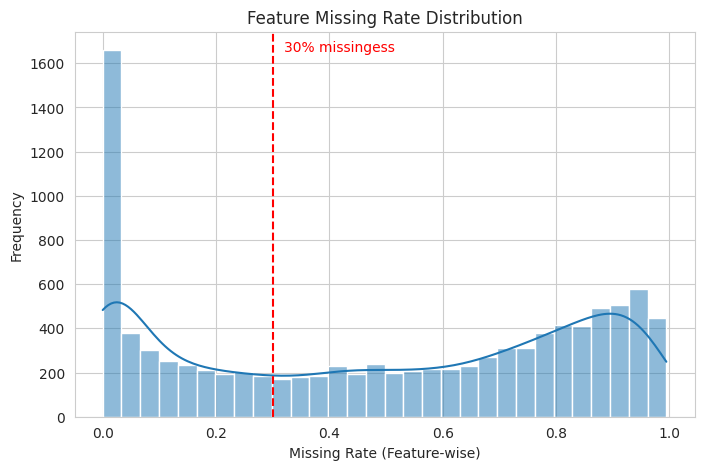

In [7]:
# Feature Missing Rate Distribution
plt.figure(figsize=(8, 5))
sns.histplot(raw_df.isna().mean(axis=0), kde=True, bins=30)
plt.axvline(x = .3, color = "red", linestyle = '--')
plt.text(.32, plt.ylim()[1]*0.95, '30% missingess', color='red', fontsize=10, ha='left')
plt.title('Feature Missing Rate Distribution')
plt.xlabel('Missing Rate (Feature-wise)')
plt.ylabel('Frequency')
plt.show()

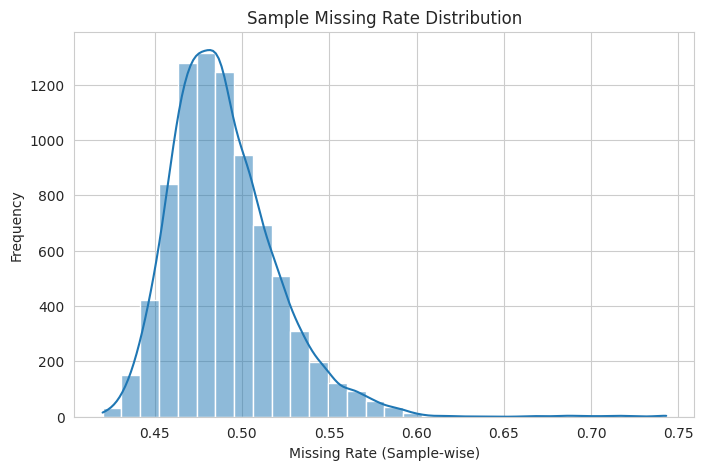

In [8]:
# Sample Missing Rate Distribution
plt.figure(figsize=(8, 5))
sns.histplot(raw_df.isna().mean(axis=1), kde=True, bins=30)
plt.title('Sample Missing Rate Distribution')
plt.xlabel('Missing Rate (Sample-wise)')
plt.ylabel('Frequency')
plt.show()

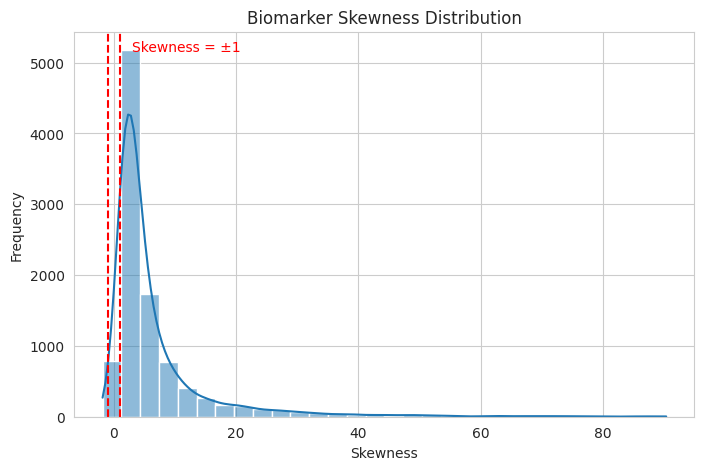

In [9]:
# Biomarker Skewness Distribution
biomarker_cols = [col for col in raw_df.columns if col.startswith('mtb_')]
skewness = raw_df[biomarker_cols].apply(lambda x: stats.skew(x.dropna()))

plt.figure(figsize=(8, 5))
sns.histplot(skewness, kde=True, bins=30)
plt.axvline(x = 1, color = "red", linestyle = '--')
plt.axvline(x = -1, color = "red", linestyle = '--')
plt.text(3, plt.ylim()[1]*0.95, 'Skewness = ±1', color='red', fontsize=10, ha='left')
plt.title('Biomarker Skewness Distribution')
plt.xlabel('Skewness')
plt.ylabel('Frequency')
plt.show()

## Encode Categorical Data

In [10]:
raw_df['sex'] = raw_df['sex'].map({'male': 1, 'female': 0})
raw_df['incident_diabetes'] = raw_df['incident_diabetes'].map({1.0: True, 0.0: False})
raw_df['prevalent_diabetes'] = raw_df['prevalent_diabetes'].map({1.0: True, 0.0: False})

## Decide to use float (not good for imputation) or bool (not good for regression since bool+NaN == object)

## Transform Biomarkers

In [11]:
biomarker_cols = [col for col in raw_df.columns if col.startswith('mtb_')]
raw_df[biomarker_cols] = raw_df[biomarker_cols].apply(lambda x: np.log1p(x))

## Handle Missing Values

### Multivariate Imputation

In [12]:
imputed_file_path = f"{main_dir}/data/processed/X_imputed_df.pkl"

# Check if files already exist
if os.path.exists(imputed_file_path):
    logging.info(f"{imputed_file_path}: File exist. Loading imputed data...")
    X_imputed_df = pd.read_pickle(imputed_file_path)
else:
    logging.info(f"{imputed_file_path}: Files not found. Performing imputation...")
    
    # Perform imputation using the default estimator
    imputed_df = iterative_imputation(
        raw_df=raw_df, 
        missing_threshold=0.3,  # Drop columns with >30% missingness
        exclude_cols=[
            'subject_id', 
            'incident_diabetes', 
            'diabetes_followup_time'
        ],  # Excluded from imputation
        imputer_kwargs={
            'max_iter': 3, 
            'n_nearest_features': 50, 
            'random_state': my_random_seed, 
            'verbose': 2
        }
    )

    # Convert the 'prevalent_diabetes' column
    for col in ['sex', 'prevalent_diabetes']:
        X_imputed_df[col] = np.round(X_imputed_df[col])

    # Save output
    X_imputed_df.to_pickle(imputed_file_path)

2024-09-21 17:39:44,311 - INFO - /mnt/stsi/stsi1/sfchen/240917_sapientbio_diabetes_biomarker_project/data/processed/X_imputed_df.pkl: File exist. Loading imputed data...


### (Optional) Random Forest-Based Multivariate Imputation

In [13]:
rf_imputed_file_path = f"{main_dir}/data/processed/rf_X_imputed_df.pkl"

# Check if files already exist
if os.path.exists(rf_imputed_file_path):
    logging.info(f"{rf_imputed_file_path}: Files exist. Loading imputed data...")
    rf_X_imputed_df = pd.read_pickle(rf_imputed_file_path)
else:
    logging.info(f"{rf_imputed_file_path} Files not found. Performing imputation...")
    
    # Define the RandomForestRegressor
    random_forest_regressor = RandomForestRegressor(
        n_estimators=50, 
        random_state=my_random_seed, 
        n_jobs=-1
    )
    
    # Perform imputation with RandomForestRegressor and a custom missing threshold
    rf_X_imputed_df = iterative_imputation(
        raw_df=raw_df, 
        missing_threshold=0.3,  # Drop columns with >30% missingness
        exclude_cols=[
            'subject_id', 
            'incident_diabetes', 
            'diabetes_followup_time'
        ],  # Excluded from imputation
        estimator=random_forest_regressor,  # Custom estimator for imputation
        imputer_kwargs={'max_iter': 3, 
                        'n_nearest_features': 50, 
                        'random_state': my_random_seed, 
                        'verbose': 2
                       }
    )
    
    # Convert the 'sex' and 'prevalent_diabetes' column
    for col in ['sex', 'prevalent_diabetes']:
        rf_X_imputed_df[col] = np.round(rf_X_imputed_df[col])
    
    # Save output
    rf_X_imputed_df.to_pickle(rf_imputed_file_path)

2024-09-21 17:39:44,392 - INFO - /mnt/stsi/stsi1/sfchen/240917_sapientbio_diabetes_biomarker_project/data/processed/rf_X_imputed_df.pkl: Files exist. Loading imputed data...


# Exploratory Data Analysis (EDA)

## Demographic and Physical Distributions

count    8291.000000
mean       48.042692
std        13.149461
min        24.100000
25%        37.260000
50%        48.530000
75%        58.345000
max        74.240000
Name: age, dtype: float64


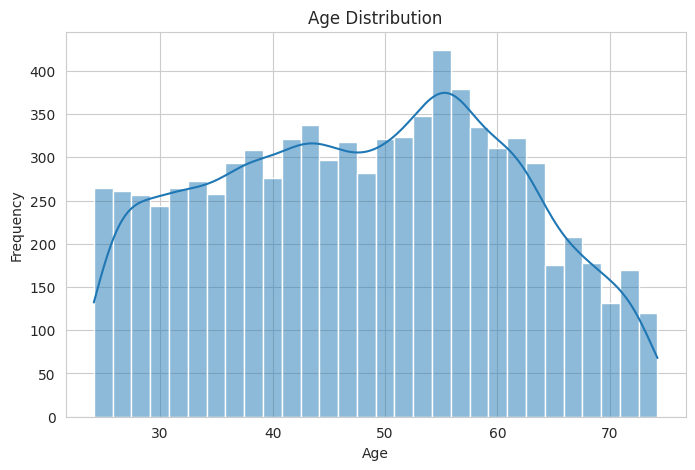

In [12]:
# Age Distribution
print(X_imputed_df['age'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(X_imputed_df['age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

sex
0    4410
1    3881
Name: count, dtype: int64


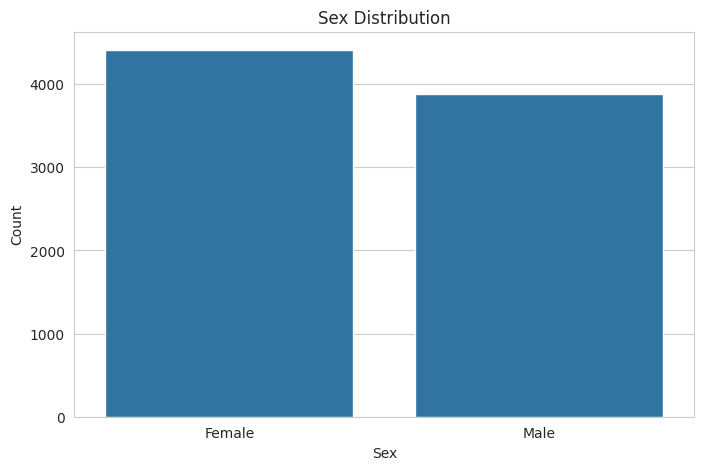

In [13]:
# Sex Distribution
print(X_imputed_df['sex'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='sex', data=X_imputed_df)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

count    8291.000000
mean       26.919283
std         4.672327
min        15.836757
25%        23.635075
50%        26.324310
75%        29.432518
max        55.979629
Name: BMI, dtype: float64


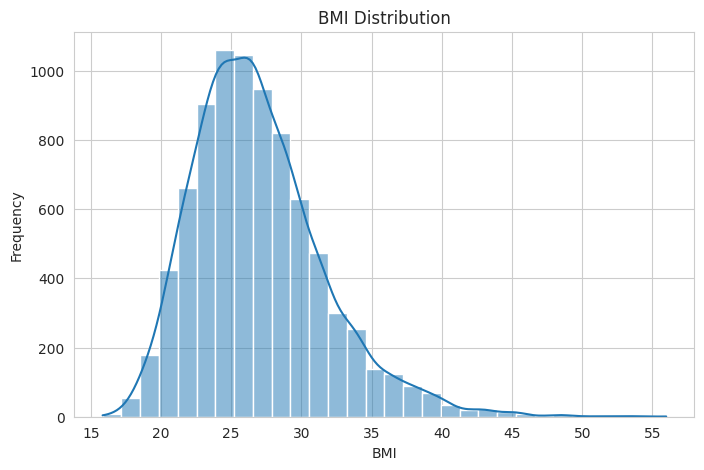

In [14]:
# BMI Distribution
print(X_imputed_df['BMI'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(X_imputed_df['BMI'], kde=True, bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

## Diabetes Distributions

prevalent_diabetes
0    7840
1     451
Name: count, dtype: int64


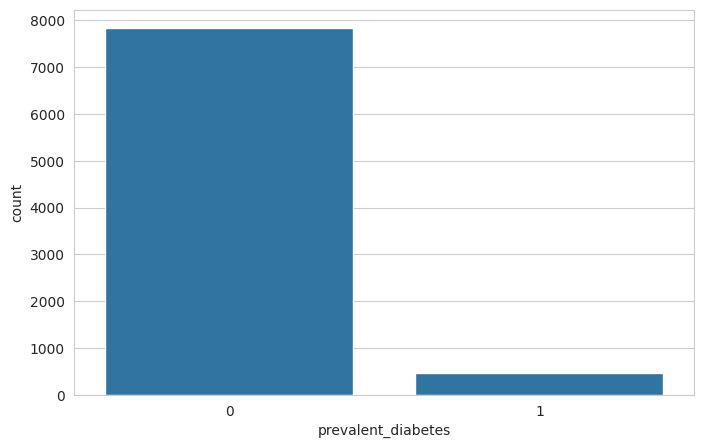

In [15]:
# Prevalent Diabetes Distribution
X_imputed_df['prevalent_diabetes'] = X_imputed_df['prevalent_diabetes'].astype(int)
print(X_imputed_df['prevalent_diabetes'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='prevalent_diabetes', data=X_imputed_df)
# plt.title('Prevalent Diabetes Distribution')
# plt.xlabel('Prevalent Diabetes')
# plt.ylabel('Count')
# plt.xticks([0, 1], ['Control', 'Case'])
plt.show()

incident_diabetes
0.0    7444
1.0     704
Name: count, dtype: int64


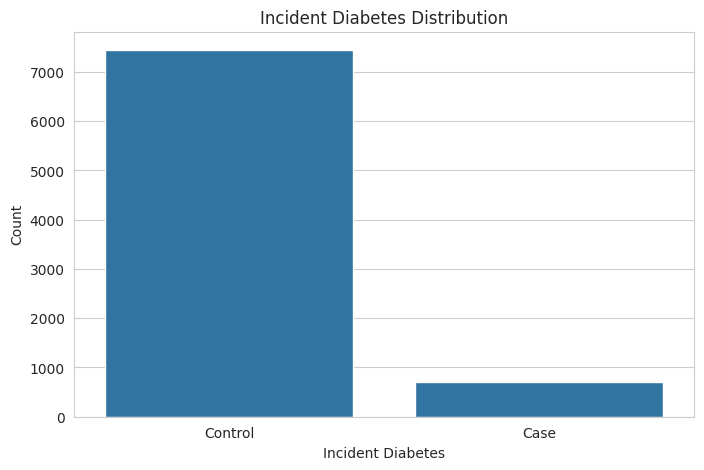

In [17]:
# Incident Diabetes Distribution
print(X_imputed_df['incident_diabetes'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='incident_diabetes', data=X_imputed_df)
plt.title('Incident Diabetes Distribution')
plt.xlabel('Incident Diabetes')
plt.ylabel('Count')
plt.xticks([False, True], ['Control', 'Case'])
plt.show()

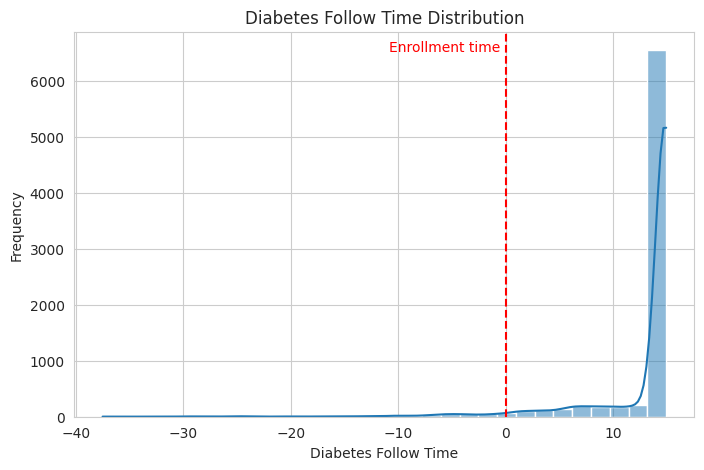

In [18]:
# Diabetes Follow Time Distribution
X_imputed_df['diabetes_followup_time'].describe()

plt.figure(figsize=(8, 5))
sns.histplot(X_imputed_df['diabetes_followup_time'], kde=True, bins=30)
plt.axvline(x = 0, color = "red", linestyle = '--')
plt.text(-0.5, plt.ylim()[1]*0.95, 'Enrollment time', color='red', fontsize=10, ha='right')
plt.title('Diabetes Follow Time Distribution')
plt.xlabel('Diabetes Follow Time')
plt.ylabel('Frequency')
plt.show()

## Label Consistency Checks

In [19]:
# Occruences of prevalent and incident diabetes
X_imputed_df.value_counts(['prevalent_diabetes', 'incident_diabetes'])

prevalent_diabetes  incident_diabetes
0                   0.0                  6993
                    1.0                   704
1                   0.0                   451
Name: count, dtype: int64

In [20]:
# Check 1: A subject should not have both prevalent and incident diabetes at the same time
assert X_imputed_df.loc[(X_imputed_df['incident_diabetes'] != 0) & (X_imputed_df['prevalent_diabetes'] != 0), ].empty, \
    "Check failed: There are subjects who have both prevalent and incident diabetes. A subject shouldn't have both at the same time."

# Check 2: If a subject has non-positive follow-up time, they should have prevalent diabetes
assert X_imputed_df.loc[(X_imputed_df['diabetes_followup_time'] <= 0) & (X_imputed_df['prevalent_diabetes'] != 1), ].empty, \
    "Check failed: There are subjects with negative follow-up time who do not have prevalent diabetes."

# Check 3: If a subject has non-positive follow-up time, they should not have incident diabetes
assert X_imputed_df.loc[(X_imputed_df['diabetes_followup_time'] <= 0) & (X_imputed_df['incident_diabetes'] != 0), ].empty, \
    "Check failed: There are subjects with negative follow-up time who have incident diabetes."

# Statistical Analysis

## Univariate Logistic Regression for Each Biomarker

## Multiple Testing Correction

## Identify Significant Biomarkers

# Visualization of Significant Biomarkers

### Volcano

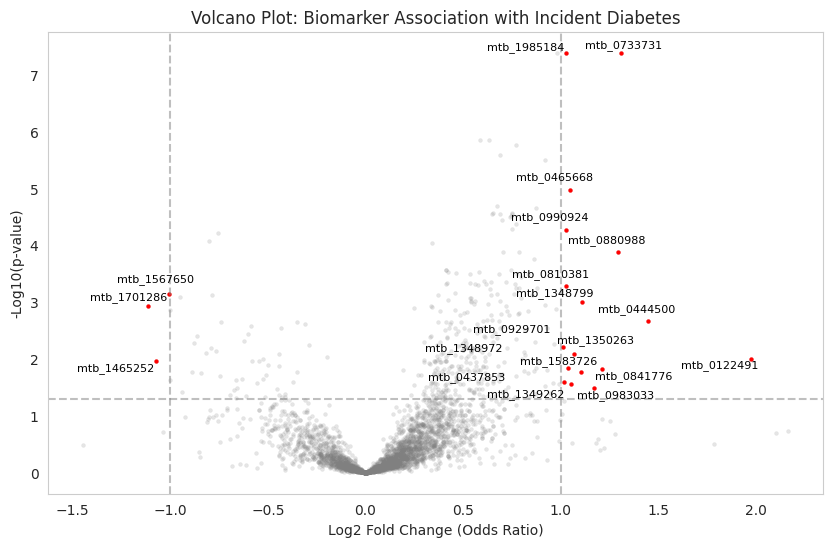

In [28]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text

# Step 1: Prepare the Data
cleaned_df = X_imputed_df.dropna(subset=['incident_diabetes']).copy()

# Step 2: Propensity Score Calculation (using covariates)
covariates = ['age', 'sex', 'BMI']
X_covariates = cleaned_df[covariates]
y = cleaned_df['incident_diabetes']

# Standardize covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_covariates)

# Logistic regression for propensity score calculation
propensity_model = LogisticRegression(solver='liblinear')
propensity_model.fit(X_scaled, y)
cleaned_df['propensity_score'] = propensity_model.predict_proba(X_scaled)[:, 1]

# Step 3: Propensity Score Matching
cases = cleaned_df[cleaned_df['incident_diabetes'] == 1].copy()
controls = cleaned_df[cleaned_df['incident_diabetes'] == 0].copy()

# Perform 1-to-1 nearest neighbor matching on propensity scores
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(controls[['propensity_score']])
distances, indices = nbrs.kneighbors(cases[['propensity_score']])

# Get matched controls
matched_controls = controls.iloc[indices.flatten()]
matched_data = pd.concat([cases, matched_controls], ignore_index=True)

# Step 4: Logistic Regression for Biomarkers
biomarker_cols = [col for col in matched_data.columns if col.startswith('mtb_')]
log2_fold_changes = []
p_values = []

for biomarker in biomarker_cols:
    # Create a dataframe with the biomarker and covariates
    X = matched_data[[biomarker] + covariates]
    X = sm.add_constant(X)  # Add constant for intercept
    
    # Fit logistic regression model
    logit_model = sm.Logit(matched_data['incident_diabetes'], X)
    result = logit_model.fit(disp=0)
    
    # Store the log2 fold change and p-value for the biomarker
    odds_ratio = np.exp(result.params.iloc[1])  # Odds ratio for the biomarker (skip the constant)
    log2_fold_changes.append(np.log2(odds_ratio))  # Log2 fold change
    p_values.append(result.pvalues.iloc[1])  # p-value for the biomarker

# Step 5: Adjust for Multiple Testing using Benjamini-Hochberg
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Step 6: Volcano Plot Data Preparation
neg_log_p_values = -np.log10(corrected_p_values)

# Create a DataFrame for plotting
volcano_data = pd.DataFrame({
    'biomarker': biomarker_cols,
    'log2FC': log2_fold_changes,
    '-log10(p-value)': neg_log_p_values
})

# Step 7: Plot the Volcano Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=volcano_data, x='log2FC', y='-log10(p-value)', color = 'grey', edgecolor=None, s = 8, alpha = 0.2)
plt.grid(False)

# Define thresholds for significance and fold change
pval_threshold = -np.log10(0.05)  # p-value < 0.05 (after adjustment)
fc_threshold = 1  # Log2 fold change threshold

# Highlight significant points
sig = volcano_data[(volcano_data['-log10(p-value)'] > pval_threshold) & (abs(volcano_data['log2FC']) > fc_threshold)]
sns.scatterplot(data=sig, x='log2FC', y='-log10(p-value)', color='red', edgecolor=None, s = 8)

# Add threshold lines
plt.axhline(y=pval_threshold, color='grey', linestyle='--', alpha = 0.5)
plt.axvline(x=1.0, color='grey', linestyle='--', alpha = 0.5)
plt.axvline(x=-1.0, color='grey', linestyle='--', alpha = 0.5)

texts = []
for i in range(sig.shape[0]):
    texts.append(plt.text(sig['log2FC'].iloc[i], sig['-log10(p-value)'].iloc[i], sig['biomarker'].iloc[i], 
                          fontsize=8, ha='right', color='black'))

# Automatically adjust text to prevent overlap
adjust_text(texts)

# Titles and labels
plt.title('Volcano Plot: Biomarker Association with Incident Diabetes')
plt.xlabel('Log2 Fold Change (Odds Ratio)')
plt.ylabel('-Log10(p-value)')
plt.show()

## Plot Top Significant Biomarkers

# Machine Learning Model

## Feature Selection

## Data Splitting

## Model Training

## Model Evaluation

### ROC AUC Score

### Classification Report

### Confusion Matrix

## ROC Curve

# Discussion

1. The study cohort has relative higher overall case rate (13.9%) at the end of follow-up period than general Americans in 2021 (11.6%) according to AHA (https://diabetes.org/about-diabetes/statistics/about-diabetes).

## Interpretation of Significant Biomarkers

## Model Performance

## Limitations

# Conclusion

# References